<a href="https://colab.research.google.com/github/Siu0901/AI_study/blob/main/%EB%84%A4%EA%B1%B0%ED%8B%B0%EB%B8%8C_%EC%83%98%ED%94%8C%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 기존 Word2Vec은 모든 단어에 대한 임베딩 벡터값을 업데이트함
# 만약 단어 집합의 크기가 수만 이상이 되면 굉장히 무거운 작업이 됨

# 모든 임베딩 값을 업데이트 하므로 현재 중심 단어와 별 의미 없는 단어들도
# 같이 업데이트 하기에 비효율적임

# 그래서 중심 단어의 주변 단어와 그 외 일부 단어만 가져와 전체보다 훨씬 작은
# 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환함 (긍정, 부정)
# 이렇게 만들면 Word2Vec보다 훨씬 연산량이 효율적임

In [2]:
# 20뉴스그룹 데이터 전처리 하기
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [4]:
documents[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [5]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ", regex=True)

# 길이가 3이하인 단어는 제거
news_df.clean_doc = news_df.clean_doc.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [6]:
news_df.isnull().values.any()

np.False_

In [7]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

np.True_

In [8]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [9]:
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# 단어가 1개 이하인 샘플은 제거.
cleaned_tokenized_doc = [sentence for sentence in tokenized_doc if len(sentence) > 1]
tokenized_doc = cleaned_tokenized_doc
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [12]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [13]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


In [14]:
# 네거티브 샘플링을 통한 데이터셋 구성하기
#  케라스에서 제공하는 전처리 도구인 skipgrams 사용

from tensorflow.keras.preprocessing.sequence import skipgrams
import random

# 네거티브 샘플링
# seed 값을 명시적으로 설정하여 난수 생성 오류 방지
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10, seed=42) for sample in encoded[:10]]

In [15]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0],
          idx2word[pairs[i][1]], pairs[i][1],
          labels[i]))

(away (178), confronting (32719)) -> 0
(holocaust (2669), faraday (49113)) -> 0
(government (51), hast (13123)) -> 0
(least (87), kory (24751)) -> 0
(think (6), subsidizing (15228)) -> 1


In [16]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [17]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [18]:
# 모든 뉴스그룹 샘플에 대해서 수행
kip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10,seed=42) for sample in encoded]

In [19]:
# Skip-Gram with Negative Sampling(SGNS) 구현하기
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [21]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │  6,427,700 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 100)    │  6,427,700 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,855,400 (49.04 MB)

 Trainable params: 12,855,400 (49.04 MB)

 Non-trainable params: 0 (0.00 B)

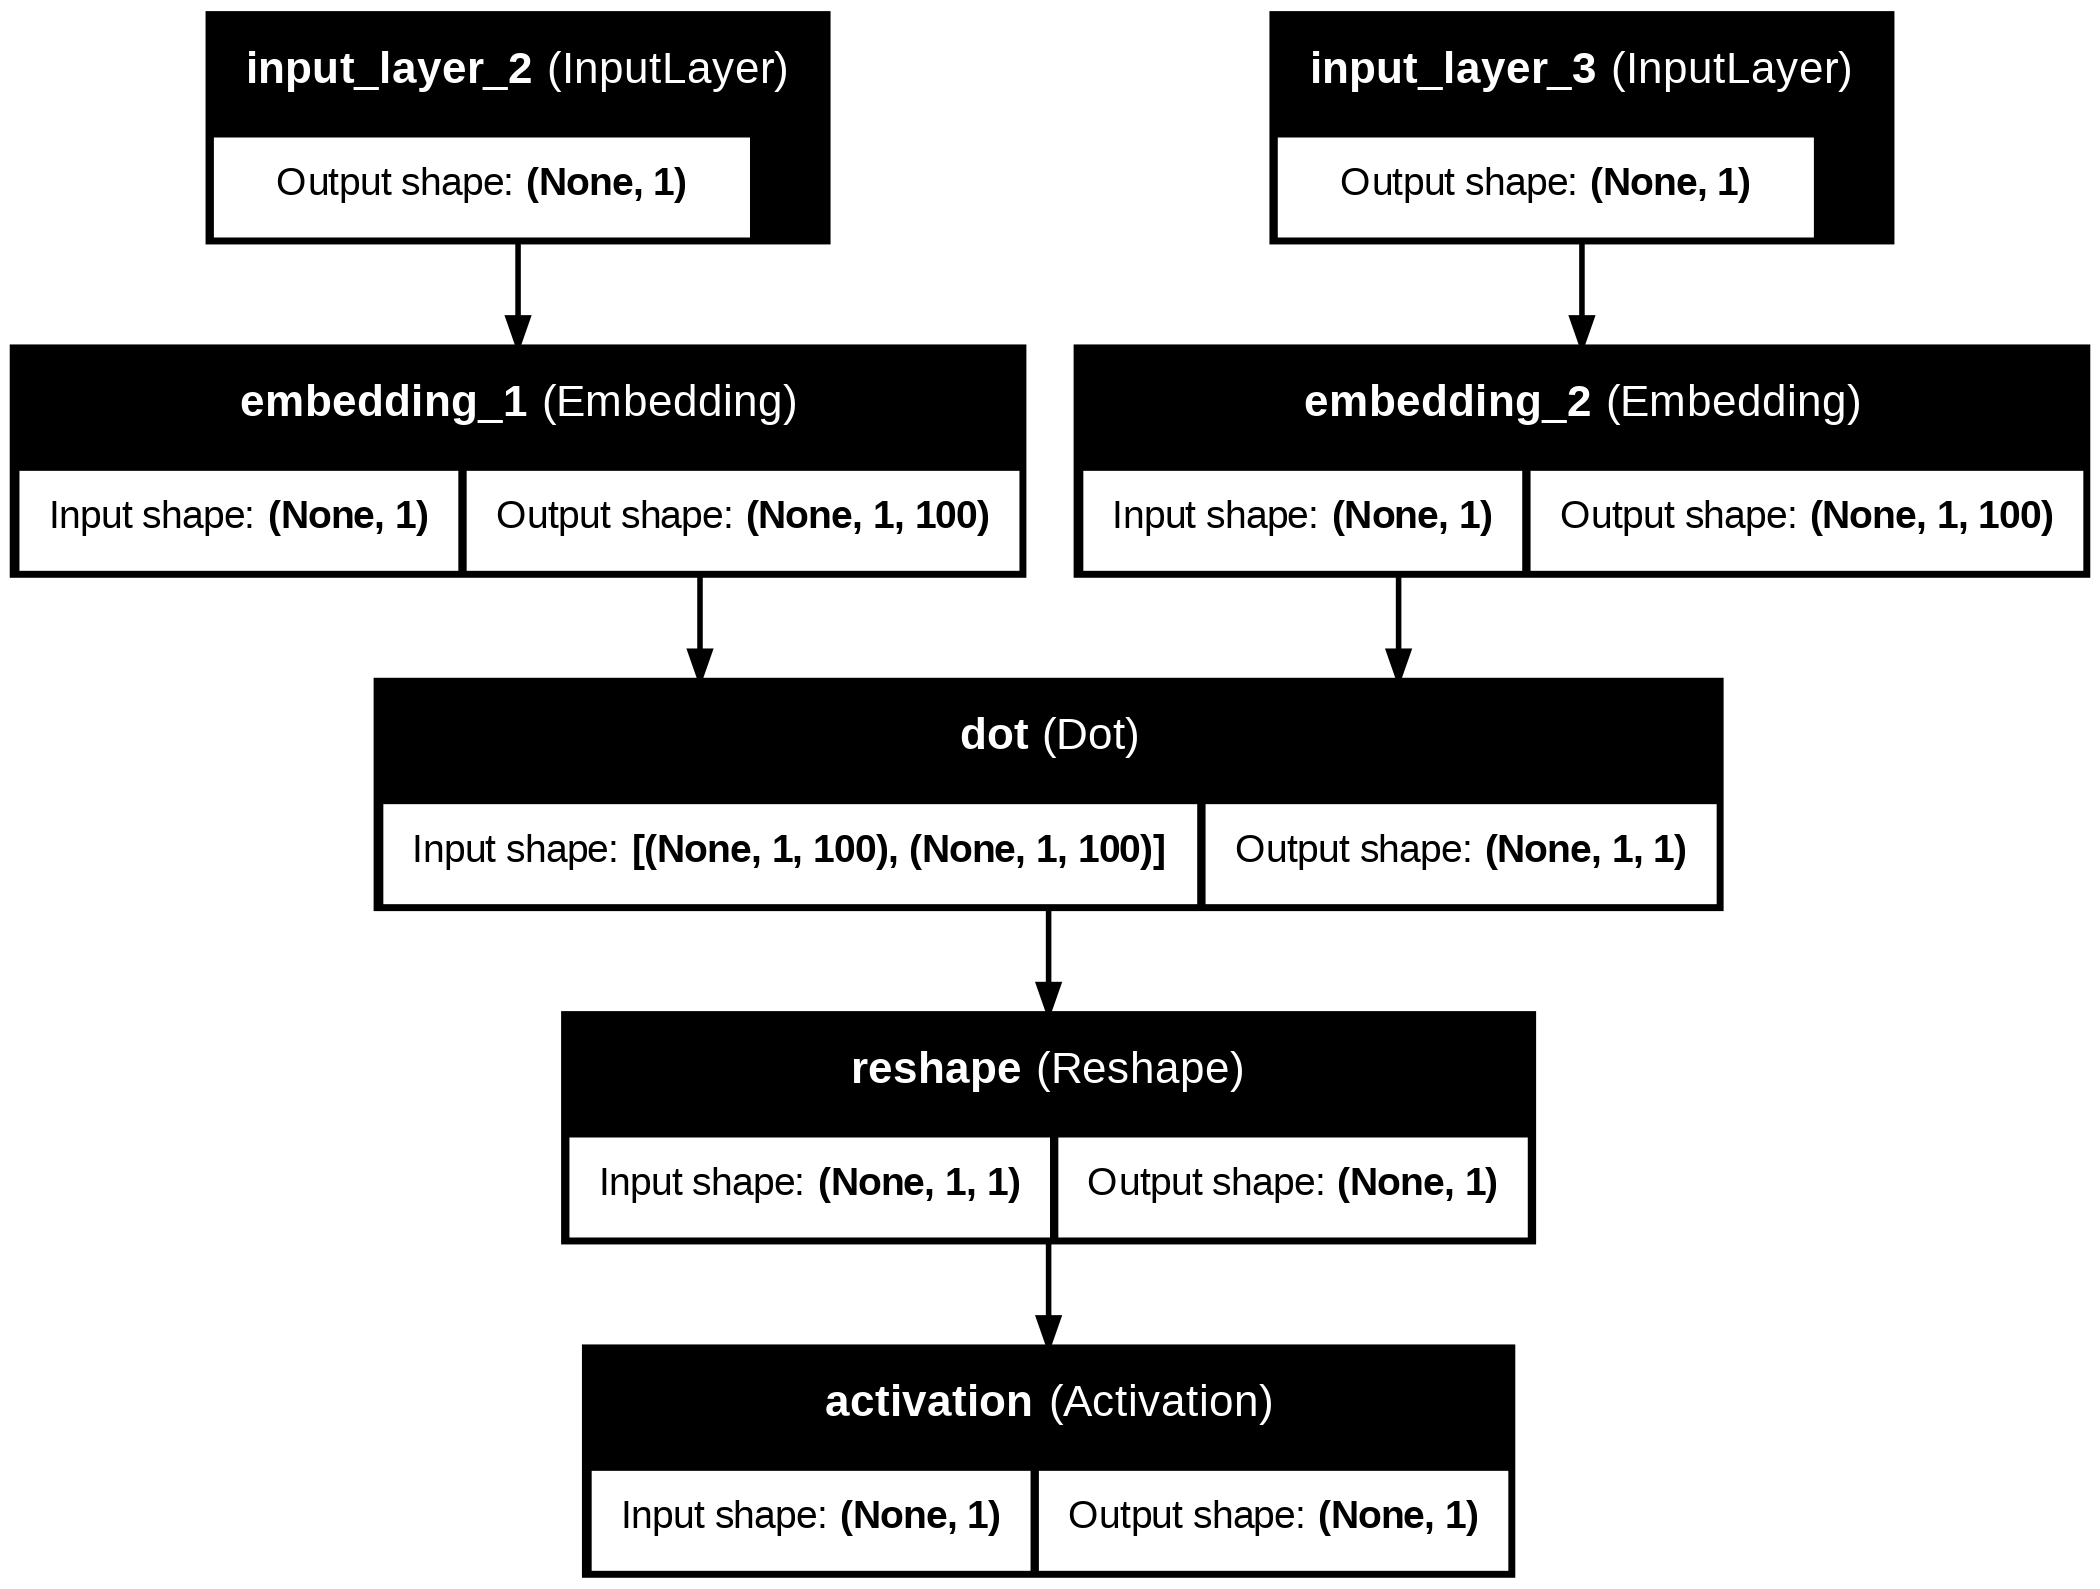

In [22]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [23]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 6.931117
Epoch : 2 Loss : 6.923049
Epoch : 3 Loss : 6.911835
Epoch : 4 Loss : 6.898805
Epoch : 5 Loss : 6.8828406


In [25]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 23.7 MB/s eta 0:00:00


In [26]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [27]:
w2v.most_similar(positive=['soldiers'])

[('ecicrl', 0.4222151041030884),
 ('census', 0.4108024537563324),
 ('acceptible', 0.3842158615589142),
 ('alphabet', 0.38146039843559265),
 ('chill', 0.37927085161209106),
 ('protogen', 0.37378671765327454),
 ('spacecraft', 0.3671720027923584),
 ('keaggy', 0.3636220693588257),
 ('isifisher', 0.35809916257858276),
 ('router', 0.35721442103385925)]

In [28]:
w2v.most_similar(positive=['doctor'])

[('silvia', 0.41136661171913147),
 ('heatofmoment', 0.3773098886013031),
 ('rrzn', 0.36640676856040955),
 ('joni', 0.36148345470428467),
 ('vnon', 0.361329048871994),
 ('burasi', 0.3600538969039917),
 ('libman', 0.3508261740207672),
 ('ballentine', 0.34970247745513916),
 ('lira', 0.3494822680950165),
 ('rakim', 0.34901803731918335)]

In [29]:
w2v.most_similar(positive=['police'])

[('garry', 0.42378121614456177),
 ('panasonic', 0.40645164251327515),
 ('doberman', 0.393710732460022),
 ('losangeles', 0.38159728050231934),
 ('lhzrlhzv', 0.3799063265323639),
 ('matenadaran', 0.3749103844165802),
 ('telefinder', 0.37286582589149475),
 ('configurenotify', 0.37158480286598206),
 ('topographic', 0.36759746074676514),
 ('subjecting', 0.3644963502883911)]

In [30]:
# 뭐지 분명 그대로 따라 했는데 결과가 망해버림